# <div align = 'center'> Lectura 11 Series de Tiempo VI</div>
<div align = 'left'>
      <font color = 'black' size = 4>
        <strong>Ciencias Administrativas - Universidad Nacional Mayor de San Marcos <br>
        Econometría Financiera<br>
        Semestre 2021-I<br>
        Setiembre 2021<br>
        Profesor: Fritz Sierra Tintaya<br>
          </font>
        </div>
        
### Contenido
  <div align = 'left'>
      <font color = 'steelblue' size = 4>
        11.1 Modelado de series tiempo: SARIMA<br>
          11.2. Importación de la Data<br>
          11.3. Estacionalidad<br>
          11.4. Estacionariedad<br>
          11.5. Modelado<br>
          11.6. Diagnóstico de residuos<br>
          11.7. Evaluación del modelo<br>
          11.8. Forecast<br>
          </font>
        </div>

## 1.  Modelado de series tiempo: SARIMA
Vamos a pronosticar las temperaturas medias mensuales hasta el año 2050 de Río de Janeiro. Para ello utilizaremos un modelo ARIMA estacional (SARIMA).

El conjunto de datos utilizado se encuentra en [Berkeley Earth] (http://berkeleyearth.lbl.gov/city-list/) y contiene información meteorológica de todo el mundo.

Comenzamos nuestro análisis importando las bibliotecas y el conjunto de datos


In [15]:
#importando bibliotecas y módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## 2.  Importación de la Data

A continuación, vemos que nuestros datos contienen las temperaturas medias mensuales entre 1832 y 2013 de muchas ciudaddes del mundo, comenzaremos revisando la información para la ciudad de Río de Janeiro

In [16]:
#Importando los datos y colocando la columna de fecha como índice. Entonces, ya tenemos una serie
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv',usecols=['dt', 'AverageTemperature', 'City'], 
                 parse_dates=['dt'], index_col='dt') 
df


,AverageTemperature,City
dt,,
1849-01-01,26.704,Abidjan
1849-02-01,27.434,Abidjan
1849-03-01,28.101,Abidjan
1849-04-01,26.140,Abidjan
1849-05-01,25.427,Abidjan
...,...,...
2013-05-01,18.979,Xian
2013-06-01,23.522,Xian
2013-07-01,25.251,Xian


In [17]:
#tomando datos de Río de Janeiro de 1851
rio_df = df[df.City == 'Rio De Janeiro']
rio_df

,AverageTemperature,City
dt,,
1832-01-01,25.320,Rio De Janeiro
1832-02-01,26.584,Rio De Janeiro
1832-03-01,25.419,Rio De Janeiro
1832-04-01,23.405,Rio De Janeiro
1832-05-01,22.773,Rio De Janeiro
...,...,...
2013-05-01,24.443,Rio De Janeiro
2013-06-01,24.703,Rio De Janeiro
2013-07-01,23.768,Rio De Janeiro


In [18]:
#dropeamos la columna de la ciudad dado que ya contiene la información de Rio de Janeiro
rio_df = rio_df.drop('City', axis=1)
rio_df


,AverageTemperature
dt,
1832-01-01,25.320
1832-02-01,26.584
1832-03-01,25.419
1832-04-01,23.405
1832-05-01,22.773
...,...
2013-05-01,24.443
2013-06-01,24.703
2013-07-01,23.768


In [19]:
rio_df.head()

,AverageTemperature
dt,
1832-01-01,25.320
1832-02-01,26.584
1832-03-01,25.419
1832-04-01,23.405
1832-05-01,22.773


<AxesSubplot:xlabel='dt'>

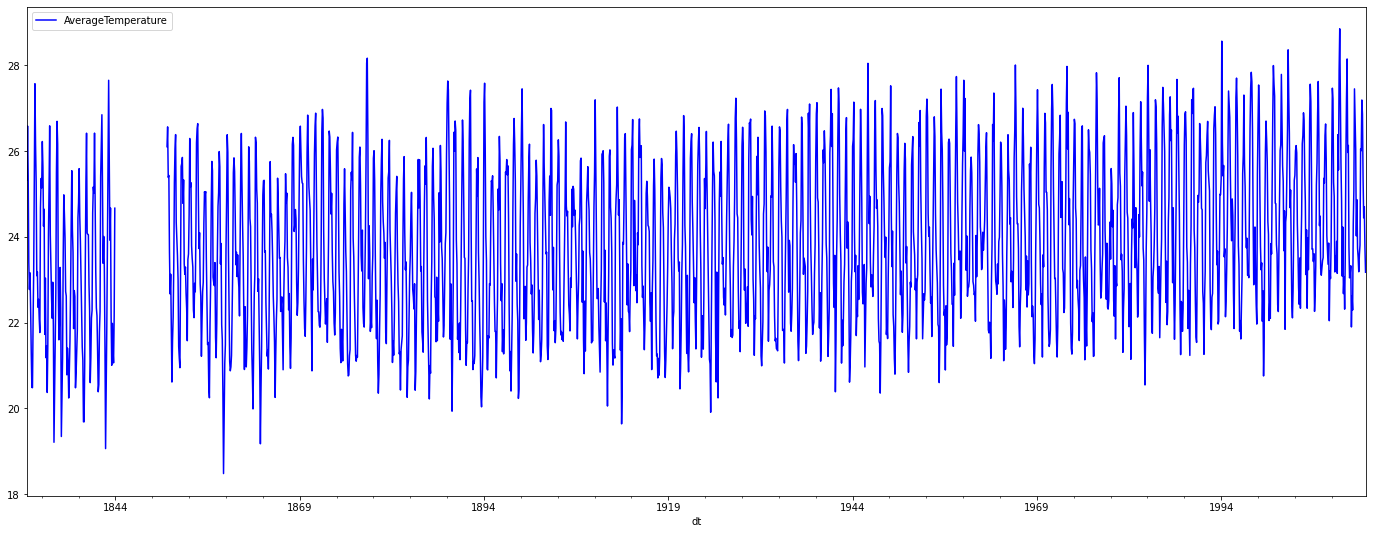

In [20]:
rio_df.plot(figsize=(24,9), c='b')

Parece que tenemos un intervalo de periodos que no tenemos datos, de los años 1844 y 1850. Echemos un vistazo más de cerca:

<AxesSubplot:xlabel='dt'>

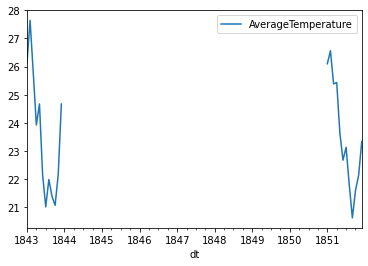

In [21]:
rio_df.loc['1843':'1851'].plot()

Entre 1844 y 1851 no tenemos datos de temperatura. Para evitar tener que lidiar con estos datos faltantes, eliminemos del análisis todo lo que viene antes de 1851. De esta manera, nuestra serie cubre el rango de 1851 a 2013, que creo que es suficiente para nuestros datos modelados.

<AxesSubplot:xlabel='dt'>

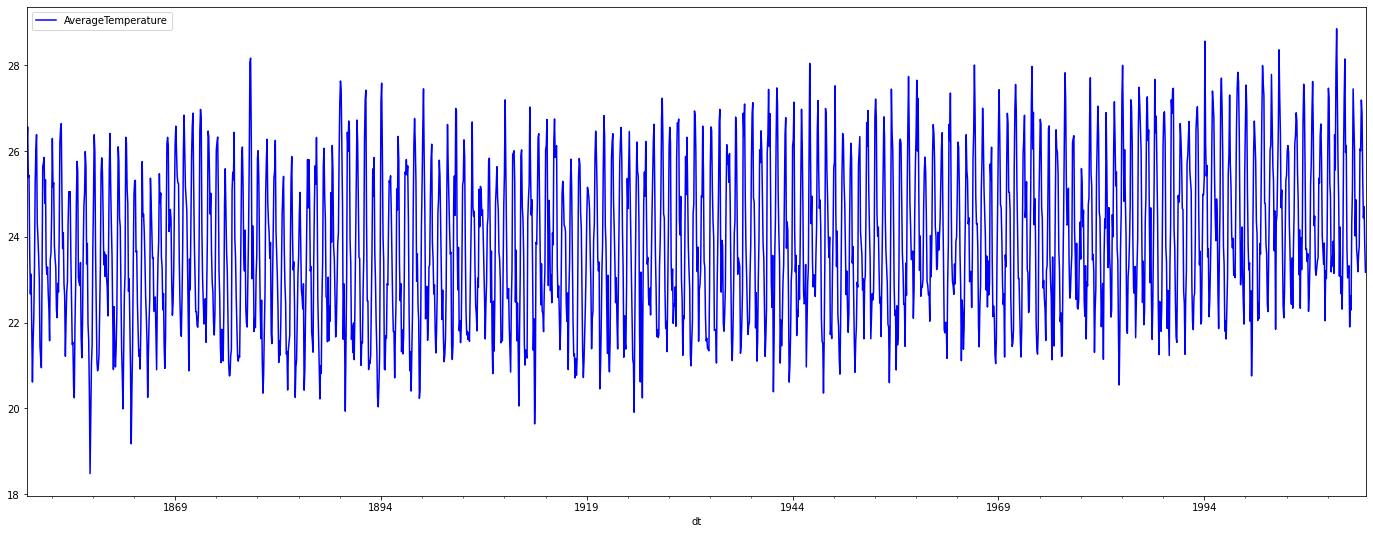

In [22]:
rio_df = rio_df.loc['1851':]
rio_df.plot(figsize=(24,9), c='b')

Podemos ver a continuación que tenemos otro valor nulo único, correspondiente a la última fecha de la serie (septiembre de 2013):

In [23]:
#¿Tenemos otros valores nulos?
print('Número de valores nulos: ', rio_df.AverageTemperature.isnull().sum())

#¿En qué fecha se produce este valor nulo?
print('\n\n ¿Cuándo ocurre este valor nulo?')
print(rio_df[rio_df.AverageTemperature.isnull()])

Número de valores nulos:  1


 ¿Cuándo ocurre este valor nulo?
            AverageTemperature
dt                            
2013-09-01                 NaN


Después de eliminar este punto de datos, ya no tenemos valores nulos en la serie:

In [24]:
rio_df = rio_df.dropna()
rio_df

,AverageTemperature
dt,
1851-01-01,26.101
1851-02-01,26.563
1851-03-01,25.385
1851-04-01,25.432
1851-05-01,23.648
...,...
2013-04-01,25.357
2013-05-01,24.443
2013-06-01,24.703


Antes de continuar con el análisis, separemos nuestro conjunto de datos en conjunto de entrenamiento y conjunto de prueba. De esta forma evitamos cualquier tipo de fuga de datos en el modelado que haremos a continuación.

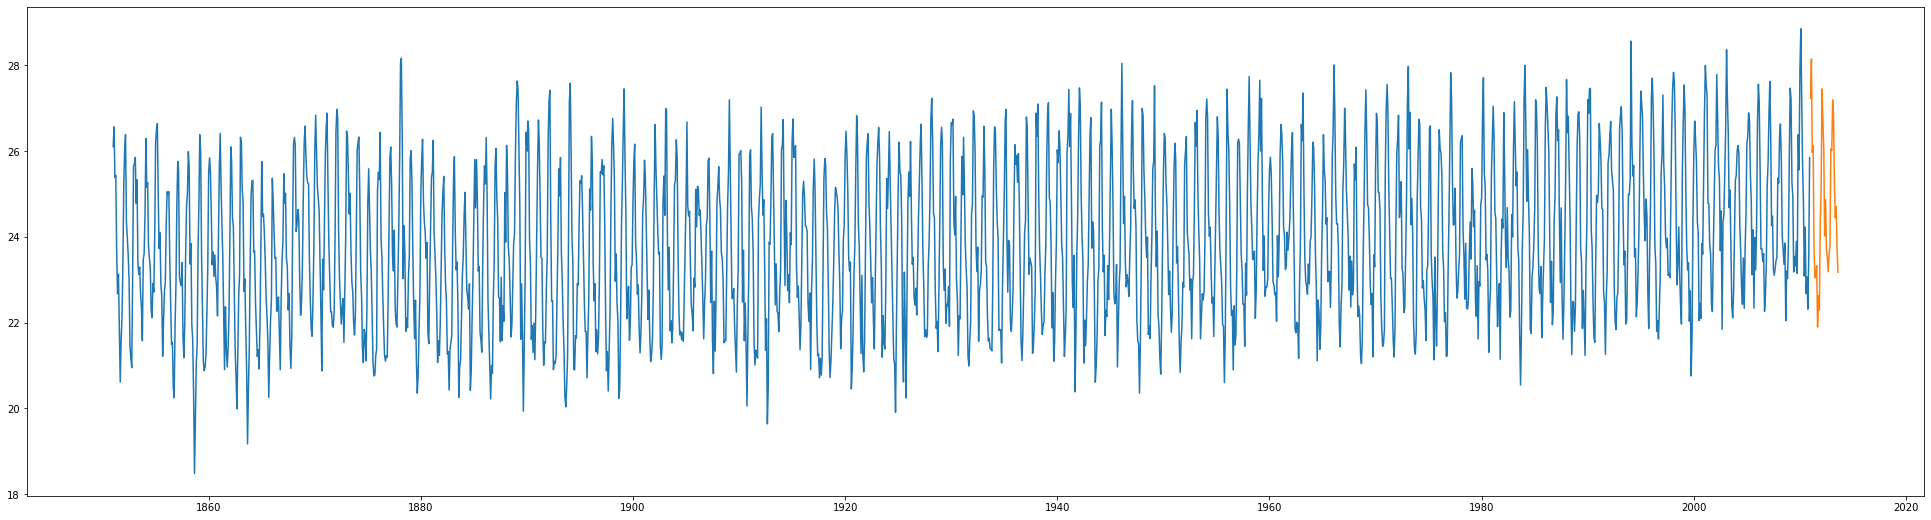

In [25]:
rio_df_train = rio_df[:'2010']
rio_df_test = rio_df['2011':]
plt.figure(figsize=(34, 9))
plt.plot(rio_df_train)
plt.plot(rio_df_test)

## 3. Estacionalidad

A continuación, mediante inspección visual, la serie parece ser estacional, con una frecuencia de 12 meses. Esta consideración se ve reforzada por nuestro conocimiento previo de la cantidad medida en la serie: las temperaturas suelen estar correlacionadas con la estación del año, que se repite cada 12 meses.

Revisemos este período de estacionalidad observando el gráfico ACF a continuación.

<AxesSubplot:xlabel='dt'>

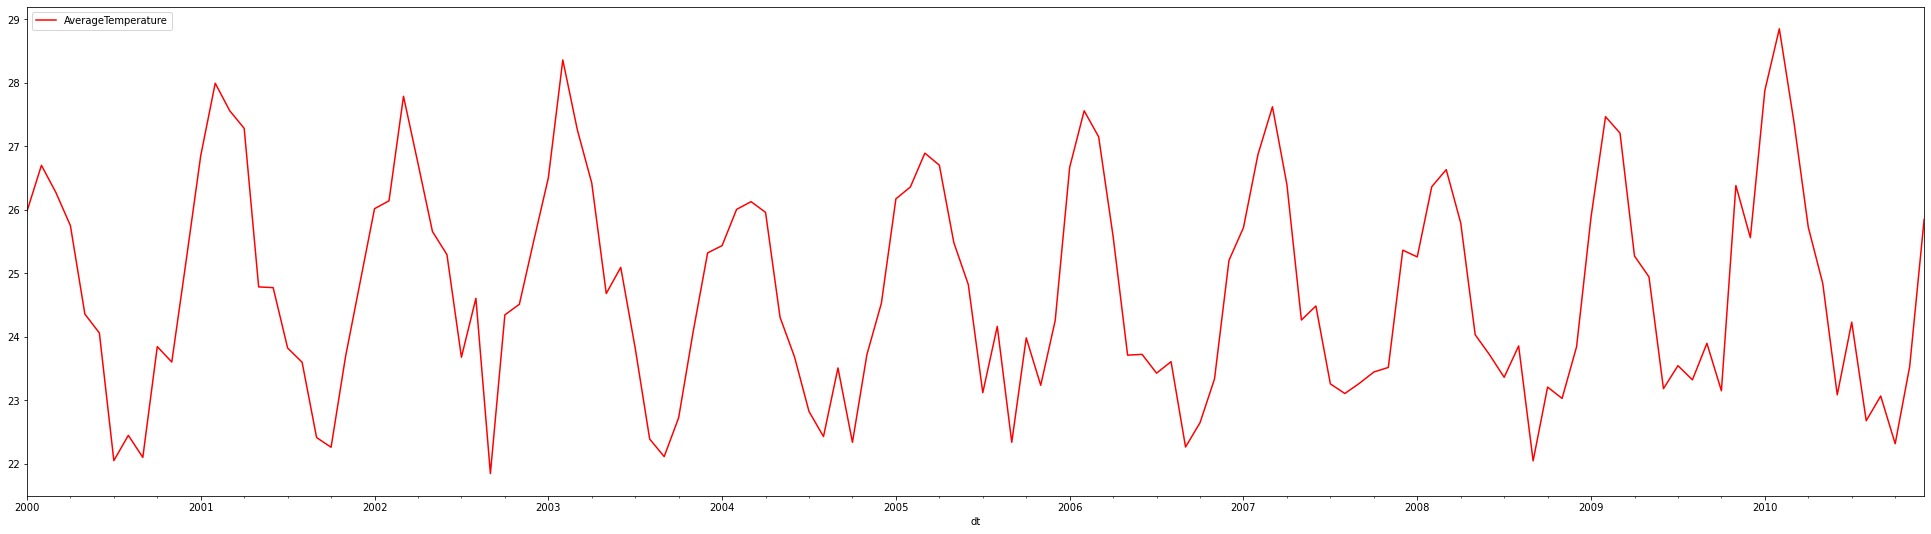

In [26]:
rio_df_train.loc['2000':].plot(c='r',figsize=(34, 9))

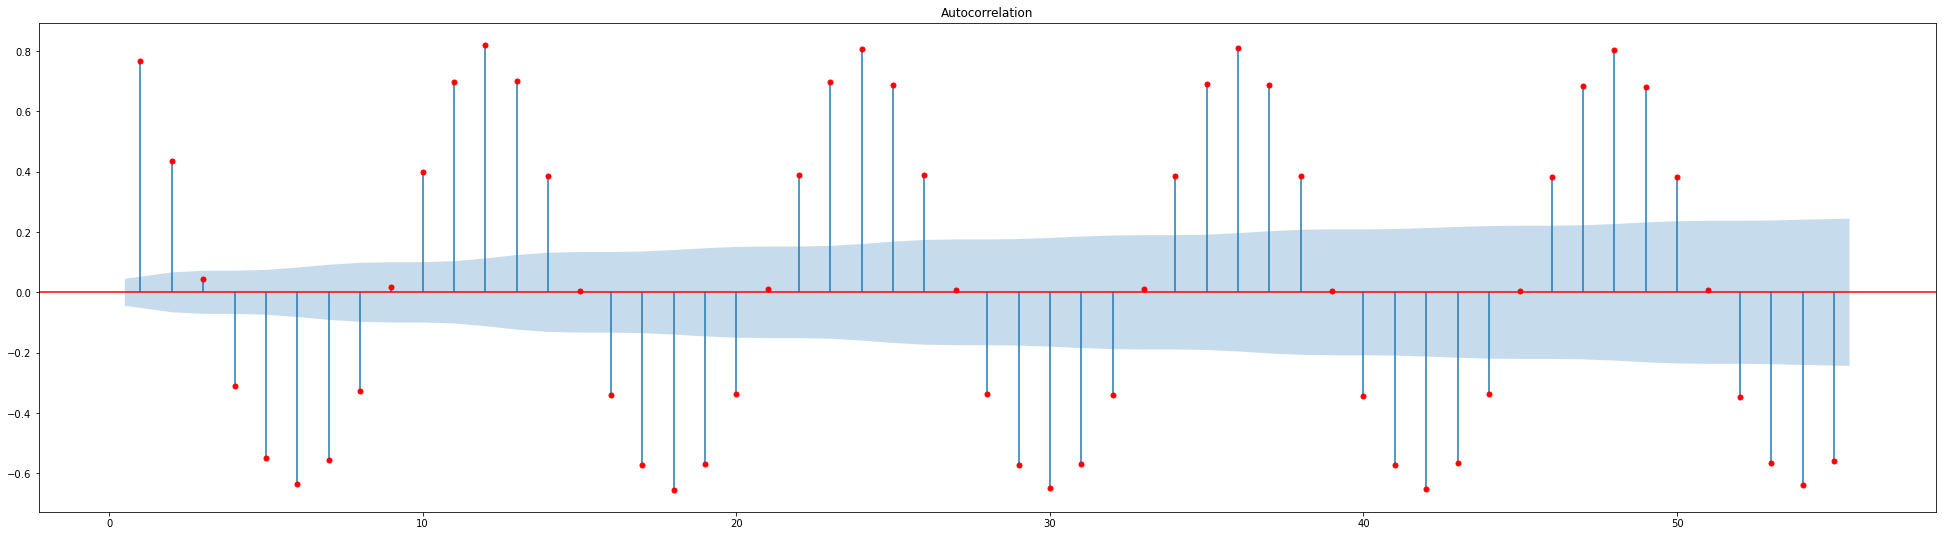

In [27]:
#Graficando el ACF:
fig, ax1 = plt.subplots(figsize=(34, 9))
plot_acf(rio_df_train.AverageTemperature, lags=55, zero=False,  ax=ax1, color='red')
plt.show()

De hecho, encontramos una frecuencia de estacionalidad de 12 meses, ya que el ACF muestra una alta correlación positiva con rezagos múltiples de 12 meses.

Otro comportamiento de la serie que podemos observar en el ACF es que, en "múltiplos impares" de 6 meses (6 * 1, 6 * 3, 6 * 5, ...) encontramos una fuerte correlación negativa. Esto se debe a que, si hoy es verano, en 6 meses será invierno. Así, una temperatura más alta (típica de verano) se relaciona con una temperatura más baja (típica de invierno) con un rezago de 6 meses.

Habiendo encontrado el período de estacionalidad, podemos descomponer la serie de tiempo en 3 partes: la tendencia, la estacionalidad y los residuos locales:

In [51]:
print(rio_df_train)

            AverageTemperature
dt                            
1851-01-01              26.101
1851-02-01              26.563
1851-03-01              25.385
1851-04-01              25.432
1851-05-01              23.648
...                        ...
2010-08-01              22.677
2010-09-01              23.066
2010-10-01              22.315
2010-11-01              23.529
2010-12-01              25.848

[1920 rows x 1 columns]


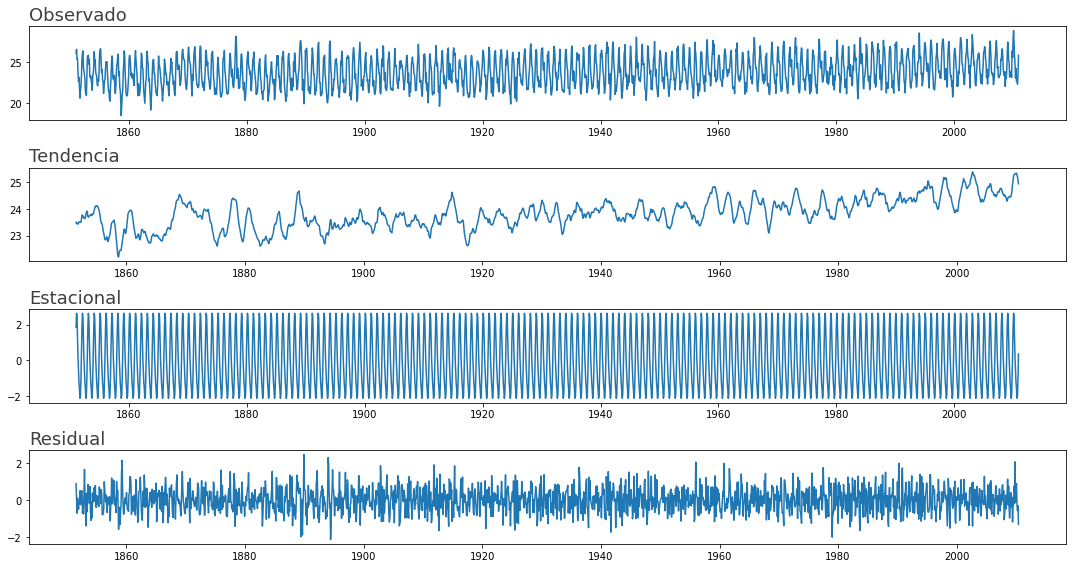

In [28]:
#Descomponiendo la serie en tendencia, estacionalidad y residuos:
seasonal_dec = seasonal_decompose(rio_df_train.AverageTemperature, period = 12)

ax, fig = plt.subplots(figsize=(15,8), sharex=True)

plt.subplot(411)
plt.plot(rio_df_train.AverageTemperature, label="Original")
plt.title("Observado",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(seasonal_dec.trend, label="Tendencia")
plt.title("Tendencia",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal_dec.seasonal, label="Estacional")
plt.title("Estacional",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(seasonal_dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

Observamos que hay una tendencia creciente en la temperatura, especialmente después de 1960, mientras que el factor de estacionalidad parece tener una influencia constante a lo largo de todo el período.

## 4. Estacionariedad

Antes de continuar con nuestro modelado, necesitamos estudiar la estacionariedad de la serie, que es una suposición del modelo ARIMA que pretendemos utilizar.

In [29]:
#test ADF
result = adfuller(rio_df_train.AverageTemperature)
#p-valor:
print('p-valor: ', result[1])

p-valor:  0.0008277657777735069


La prueba ADF mostró un valor p de 0.00082. Por tanto, podríamos rechazar la hipótesis nula de no estacionariedad y concluir que la serie es estacionaria.

Sin embargo, vimos que la serie es claramente estacional. Una serie estacional no puede ser estacionaria, por definición, ya que la media de la serie depende de la época del año en que medimos la temperatura. La prueba ADF nos engañaría, en este caso, porque mide particularmente la estacionariedad de una tendencia.

Por tanto, es necesario que eliminemos la estacionalidad de la serie para hacerla estacionaria. Solo después de eso podremos ajustar un modelo ARIMA confiable.

Para eliminar la estacionalidad de la serie, hagamos las diferencias con un retraso igual al período de estacionalidad de 12 meses:

In [30]:
#Eliminar las diferencias con un retraso de 12 meses y desechar los valores nulos generados
rio_df_diff = rio_df_train.copy()
rio_df_diff.AverageTemperature = rio_df_train.AverageTemperature.diff(12)
rio_df_diff = rio_df_diff.dropna()

In [31]:
rio_df_diff

,AverageTemperature
dt,
1852-01-01,-0.840
1852-02-01,-0.524
1852-03-01,0.998
1852-04-01,-1.092
1852-05-01,0.338
...,...
2010-08-01,-0.644
2010-09-01,-0.830
2010-10-01,-0.834


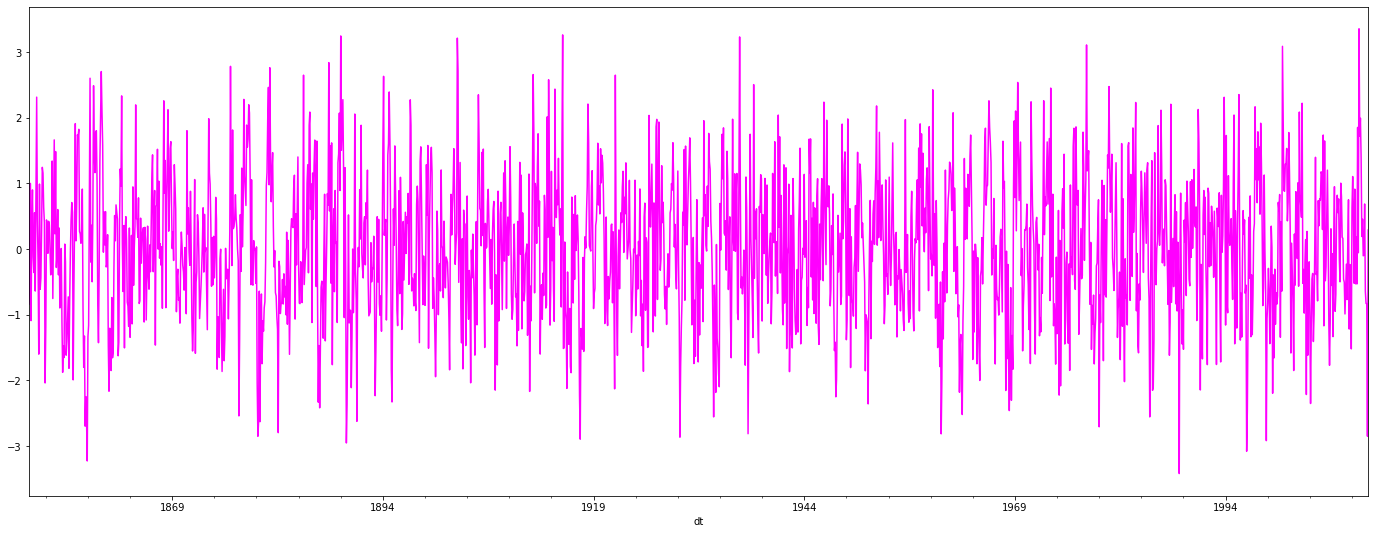

In [32]:
#Graficando la serie de diferencias de 12 meses
rio_df_diff.AverageTemperature.plot(figsize=(24,9), color='fuchsia')
plt.show()

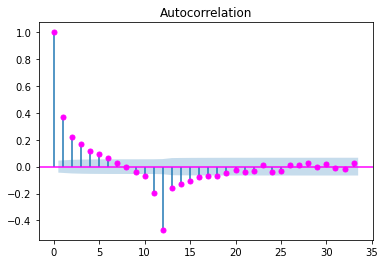

In [33]:
plot_acf(rio_df_diff.AverageTemperature, c='fuchsia')
plt.show()

In [37]:
#Test ADF
result = adfuller(rio_df_diff.AverageTemperature)
#P-valor:
print('p-valor: ', result[1])

p-valor:  6.609069626036845e-23


A partir del gráfico, la serie de diferencias de rezago de 12 meses parece ser estacionaria. Esto está fuertemente respaldado por una nueva prueba ADF con un valor p de e-23.

De esa forma, podemos continuar con el modelado de la serie.

## 5. Modelado

Como la serie es estacional, optaremos por un modelo SAMIRA. El modelo SAMIRA se compone de dos partes: un ARIMA no estacional, de órdenes (p, d, q), y un ARIMA estacional, de órdenes (P, D, Q) S, donde:

* p y P son las órdenes del respectivo AR.

* d y D son los órdenes de diferenciación.

* q y Q son las órdenes del respectivo MA.

* S es el período de estacionalidad.

Ya hemos determinado que ```S = 12 meses```. Además, para hacer la serie estacionaria, hicimos una única diferenciación múltiple de estacionalidad (por lo tanto, D = 1), y no hicimos ninguna otra diferenciación (por lo tanto, d = 0).

Los órdenes (p. Ej., P) del AR y (q y Q) del MA pueden inferirse de los gráficos ACF y PACF, o pueden determinarse mediante los criterios de información (p. Ej., AIC) encontrados para los diferentes modelos entrenados con cada conjunto de pedidos. Usaremos el método del criterio de información para encontrar el modelo SARIMA óptimo.

Para buscar los modelos, usaremos la biblioteca pmdarima, creada para imitar la función AUTOARIMA del lenguaje R. El propósito de esta biblioteca es entrenar modelos ARIMA con diferentes conjuntos de órdenes, y ver cuál de estos modelos tiene la información más baja. criterios:

In [ ]:
#Antes de ejecutar esta sentencia, verificar que su computadora tenga mínimo 16 
import pmdarima as pm

#Entrenando diferentes modelos y manteniendo el AIC más pequeño
#Testeamos valores entre 0 y 3 para cada orden del modelo.
# model1 = pm.auto_arima(rio_df_train,
#                       seasonal=True, m=12,
#                       d=0, D=1,
#                       start_p=0, start_q=0, start_P=0, start_Q=0,
#                       max_p=3, max_q=3, max_P=3, max_Q=3,
#                       max_order=None,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True)
# print(model1.summary())  

La búsqueda tomó alrededor de 30 minutos para determinar que el modelo óptimo, entre los buscados, es el SARIMA (1,0,2) (3,1,0) 12. Así, la parte no estacional tiene órdenes (p, d, q) = (1,0,2) y la parte estacional tiene órdenes (P, D, Q) S = (3,1,0) 12.

A continuación, entrenamos este gran modelo usando la biblioteca statsmodels.

In [38]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(rio_df_train, order=(1,0,2), trend='c', seasonal_order=(3,1,0,12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                  AverageTemperature   No. Observations:                 1920
Model:             SARIMAX(1, 0, 2)x(3, 1, [], 12)   Log Likelihood               -2259.725
Date:                             Sat, 11 Sep 2021   AIC                           4535.449
Time:                                     13:06:18   BIC                           4579.880
Sample:                                 01-01-1851   HQIC                          4551.802
                                      - 12-01-2010                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.008      0.419      0.675      -0.012       0.019
ar.L1          0.8147      

# 6. Diagnóstico de residuos

Del resumen del modelo anterior, con una significancia del 5%, vemos que la prueba de Jarque-Bera rechaza la hipótesis nula de normalidad de los residuos y la prueba de Ljung-Box rechaza la hipótesis nula de los residuos no correlacionados. Esta es una mala señal, ya que estaríamos violando estos dos supuestos del modelo.

Para confirmar esta información, a continuación realizamos las gráficas de diagnóstico.



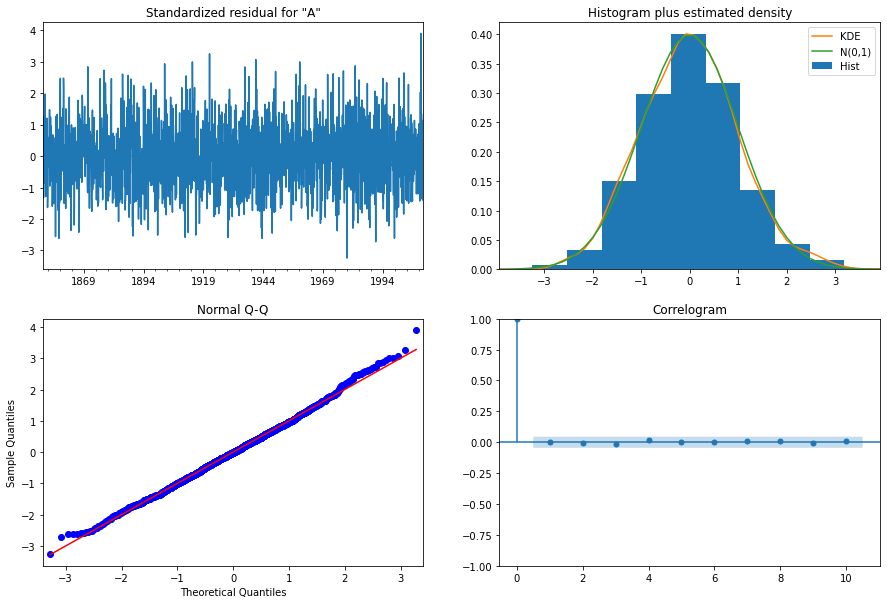

In [39]:
results.plot_diagnostics(figsize=(15,10))
plt.show()

Podemos observar por KDE que la distribución de residuos parece ser normal, lo cual es confirmado por los puntos de datos en la línea Q-Q. El correlograma, por otro lado, muestra que los residuos, de hecho, no tienen correlación. A esto se suma la serie de tiempo de los residuos, que parece ser ruido blanco, lo cual es una buena señal.

Por lo tanto, a pesar del rechazo de las pruebas de Ljung-Box y Jarque-Bera, las gráficas de diagnóstico muestran que los residuos son normales y no correlacionados. De esta forma, nuestro modelo ha pasado por el tamiz del diagnóstico de residuos y podemos utilizarlo para realizar previsiones de forma más segura.

## 7. Evaluación del modelo

#### Conjunto de entrenamiento
A continuación, trazamos las predicciones en la muestra que hizo nuestro modelo para el conjunto de entrenamiento, a partir de 1950. A modo de comparación, también trazamos los valores de temperatura reales durante este período.

In [40]:
#Error absoluto medio en el conjunto de entrenamiento
MAE = np.mean(np.abs(results.resid['1852':]))
print(f"\nMean Absolute Error en el conjunto de entrenamiento: {MAE}\n")


Mean Absolute Error en el conjunto de entrenamiento: 0.6269399081186409



In [41]:
#previsões in-sample:
predictions_train = results.predict(start=0, end=len(rio_df_train)-1)
predictions_train.name = 'train prediction'



In [42]:
predictions_train

1851-01-01     0.007068
1851-02-01     0.007079
1851-03-01     0.007085
1851-04-01     0.007090
1851-05-01     0.007093
                ...    
2010-08-01    23.780435
2010-09-01    22.746386
2010-10-01    23.177197
2010-11-01    23.865168
2010-12-01    24.804148
Freq: MS, Name: train prediction, Length: 1920, dtype: float64

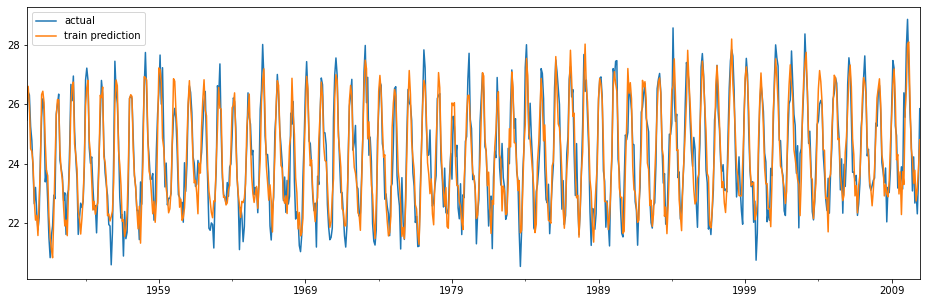

In [43]:
#Graficando los valores reales y pronósticos de 1950:
plot_df_train = pd.concat([rio_df_train.rename(columns={'AverageTemperature': 'actual'}), predictions_train], axis=1)
plot_df_train.loc['1950':].plot(figsize=(16,5))
plt.show()

Para el conjunto de entrenamiento, encontramos un error absoluto medio (MAE) de aproximadamente 0,63 ° C. Para dar dimensión a este valor, mostramos a continuación que, en el conjunto de entrenamiento, la temperatura media fue de 23,83 ° C, con una desviación estándar de 1,83 ° C y una amplitud de 10,37 ° C. Por tanto, consideramos satisfactorio el resultado.

In [44]:
media, dp, amplitud = rio_df_train.mean()[0], rio_df_train.std()[0], (rio_df_train.max() - rio_df_train.min())[0]
print('En conjunto de entrenamiento:\nmedia :', media)
print('desviación estándar :', dp)
print('amplitud: ', amplitud)

En conjunto de entrenamiento:
media : 23.82651302083335
desviación estándar : 1.8347631698276916
amplitud:  10.366000000000003


#### Conjunto de Prueba
En el conjunto de prueba tenemos 32 puntos nunca vistos por nuestro modelo. Por lo tanto, podemos utilizar este conjunto para comprobar si las predicciones del modelo se generalizan bien a nuevos puntos o si hay algún tipo de sobreajuste en el conjunto de entrenamiento.

A continuación, trazamos las predicciones que hizo el modelo para el conjunto de prueba. A modo de comparación, también trazamos los valores de temperatura reales durante el mismo período.

In [45]:
#predicciones fuera de la muestra usando el conjunto de prueba (puntos nunca vistos por el modelo):
predictions_test = results.predict(start=(len(rio_df_train)), end=(len(rio_df_train)+len(rio_df_test)-1))
predictions_test.name = 'test prediction'



In [46]:
predictions_test

2011-01-01    26.372482
2011-02-01    27.444679
2011-03-01    27.263204
2011-04-01    25.860292
2011-05-01    24.542567
2011-06-01    23.665908
2011-07-01    23.634600
2011-08-01    23.268651
2011-09-01    23.058877
2011-10-01    23.047930
2011-11-01    24.045990
2011-12-01    25.155882
2012-01-01    26.312665
2012-02-01    27.503708
2012-03-01    27.136518
2012-04-01    25.678253
2012-05-01    24.601646
2012-06-01    23.442181
2012-07-01    23.690698
2012-08-01    23.320963
2012-09-01    23.040155
2012-10-01    22.972384
2012-11-01    24.304702
2012-12-01    25.096613
2013-01-01    26.646497
2013-02-01    27.852860
2013-03-01    27.268447
2013-04-01    25.644209
2013-05-01    24.755772
2013-06-01    23.348823
2013-07-01    23.800360
2013-08-01    23.157883
Freq: MS, Name: test prediction, dtype: float64

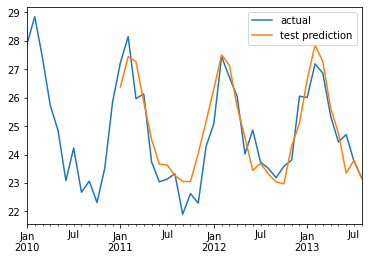

In [47]:
#Graficando los valores reales y las predicciones del conjunto de prueba
plot_df_test = pd.concat([rio_df.rename(columns={'AverageTemperature': 'actual'}), predictions_test], axis=1)
plot_df_test.loc['2010':].plot()
plt.show()

In [ ]:
#Error absoluto promedio en el conjunto de pruebas (puntos nunca vistos por el algoritmo)
residuals = plot_df_test.loc['2011':].actual - plot_df_test.loc['2011':]['test prediction']
MAE = np.mean(np.abs(residuals))
print(f"\nError absoluto promedio en el conjunto de pruebas: {MAE}\n")


Para el conjunto de prueba, encontramos un error absoluto medio (MAE) de aproximadamente 0,61 ° C. Recordando que el MAE para el conjunto de entrenamiento fue de 0,63 ° C, concluimos que nuestro modelo se generaliza bien a puntos que no se vieron en el entrenamiento.

De esta manera, podemos pronosticar fechas que no forman parte de nuestro conjunto de datos con más confianza.

Trazamos a continuación, en un solo gráfico, las temperaturas reales y las temperaturas previstas para el conjunto de entrenamiento y prueba.

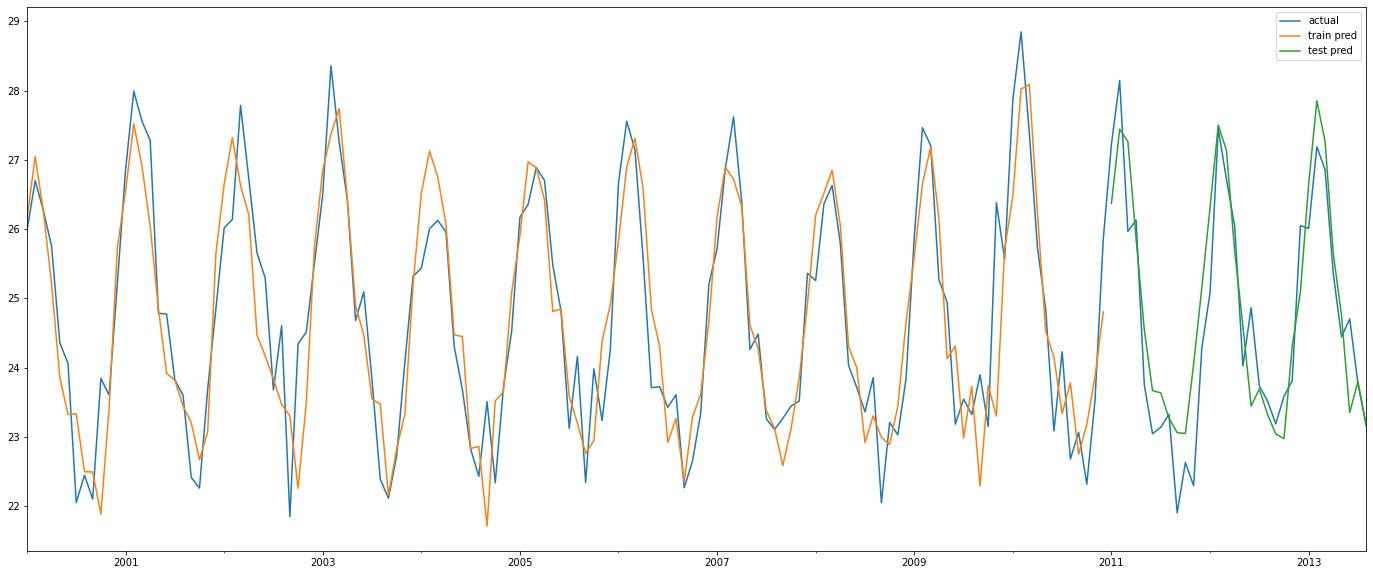

In [48]:
#Graficamos los valores reales y predicciones para conjuntos de entrenamiento y prueba
plot_df = pd.concat([rio_df.rename(columns={'AverageTemperature': 'actual'}), predictions_train.rename('train pred'), predictions_test.rename('test pred')], axis=1)
plot_df.loc['2000':].plot(figsize=(24,10))
plt.show()

## 8. Forecast
Con nuestro modelo entrenado y validado, presentamos el pronóstico de temperatura promedio hasta 2050.

In [49]:
#Pronóstico fuera de la muestra utilizando el conjunto de prueba (puntos nunca vistos por el modelo):
forecast = results.predict(start=(len(rio_df_train)+len(rio_df_test)-1), end=(len(rio_df_train)+len(rio_df_test)-1+437))
forecast.name = 'forecast'

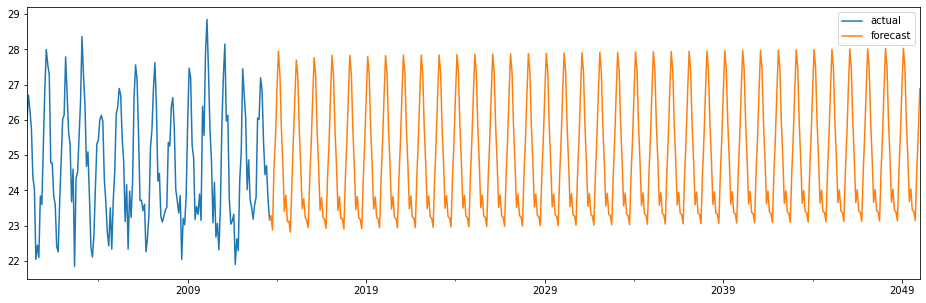

In [50]:
#Graficando lo valores
plot_df_train = pd.concat([rio_df.rename(columns={'AverageTemperature': 'actual'}), forecast], axis=1)
plot_df_train.loc['2000':].plot(figsize=(16,5))
plt.show()